In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import lfilter, cheby1, sosfilt
import numpy as np

In [2]:
def blackman_window(N):
    n = np.arange(N)
    return 0.1 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1)) # firstly 0.42

In [16]:
def band_stop_filter(N):
    window = blackman_window(N)

    # filter parameters
    w0 = 2 * np.pi / 10
    Q = 10

    # transfer function conversion
    b = [w0**2, 0, 0]
    a = [1, w0 / Q, w0**2]

    # filter use
    y_filtered = lfilter(b, a, y_noisy)
    correction = np.sum(y_filtered) * 4

    return np.convolve(y_filtered, window, mode='same') / correction


$$
z_k=cos(\dfrac{(2k-1)\pi}{2N}) sinh(\dfrac{1}{N}sinh^{-1}\epsilon) \\
p_k=j \cdot sinh (\dfrac{1}{N}sinh^{-1} \epsilon) cos(\dfrac{(2k-1)\pi}{2N}) \\
k = \dfrac{\prod\limits_{i=1}^N (-p_i)}{\prod\limits_{i=1}^N (-z_i)}
$$

In [4]:
def cheby_filter(order, ripple, Wn):
    """
    :param order: filter order
    :param ripple: maximum ripple in the passband (in dB)
    :param Wn: cutoff frequency (between 0 and 1)
    :return:
        b: numerator coefficients of the transfer function
        a: denominator coefficients of the transfer function
    """
    # Determine the poles and zeros of the analog lowpass filter
    N = order
    eps = np.sqrt(10**(ripple/10)-1)
    z = np.array([np.cos(np.pi*(2*k-1)/(2*N)) * np.sinh(np.arcsinh(1/eps)/N) + 0.j for k in range(1, N+1)])
    p = np.array([1j*np.sinh(np.arcsinh(1/eps)/N) * np.cos(np.pi*(2*k-1)/(2*N)) + 0.j for k in range(1, N+1)])
    k = np.prod(-p) / np.prod(-z)   # gain factor

    # Map analog filter to digital filter using bilinear transformation
    b, a = bilinear_transform(z, p, k, Wn)

    return b, a

In [5]:
def bilinear_transform(z, p, k, Wn):
    """
    :param z: zeros of the analog filter
    :param p: poles of the analog filter
    :param k: gain of the analog filter
    :param Wn: normalized digital cutoff frequency
    :return:
        b: numerator coefficients of the digital transfer function
        a: denominator coefficients of the digital transfer function
    """
    # Pre-warp the frequency
    warped = 2 * np.tan(np.pi * Wn / 2)

    # Apply bilinear transformation
    b = np.real(k * np.poly(z))
    a = np.real(np.poly(p))

    # Scale coefficients for unity gain
    b /= a[0]
    a /= a[0]

    # Apply frequency pre-warping
    a = np.array(a)
    b = np.array(b)
    c = np.array([1, warped])
    d = np.array([1, -warped])
    a = np.real(np.convolve(a, c+d))
    b = np.real(np.convolve(b, c-d))

    return b, a


## Source function

Text(0.5, 1.0, 'y = cos(x) + sin(x)')

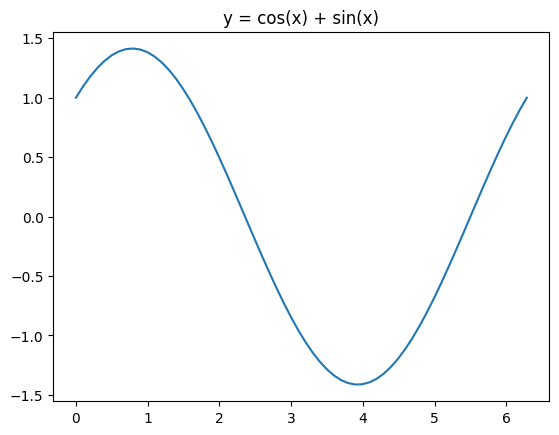

In [6]:
N = 64
x = np.linspace(0, 2 * np.pi, N)
y = list(map(lambda x: np.cos(x) + np.sin(x), x))
plt.plot(x, y)
plt.title('y = cos(x) + sin(x)')

### Amplitude

Text(0.5, 1.0, 'y = cos(x) + sin(x)')

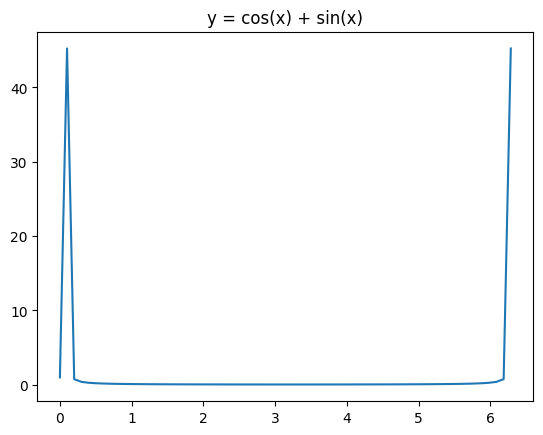

In [7]:
plt.plot(x, np.absolute(np.fft.fft(y)))
plt.title('y = cos(x) + sin(x)')

## Noise graphics

Text(0.5, 1.0, 'Noise graph')

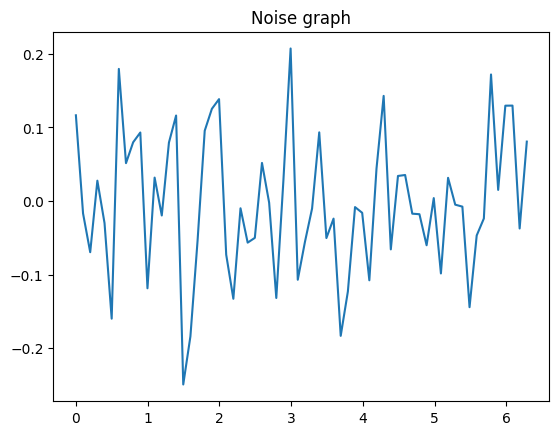

In [8]:
noise = np.random.normal(0, 0.1, N)
y_noisy = y + noise
plt.plot(x, noise)
plt.title('Noise graph')

### Amplitude

Text(0.5, 1.0, 'Noise graph')

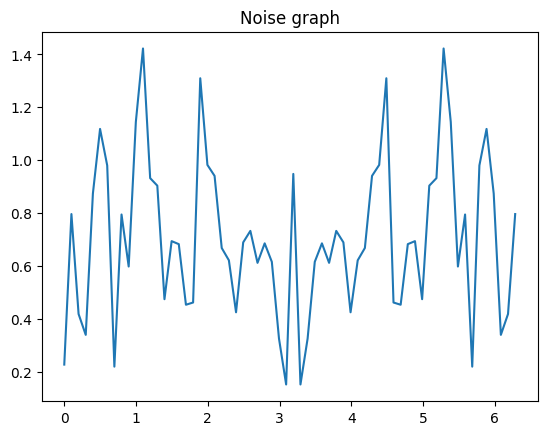

In [9]:
plt.plot(x, np.absolute(np.fft.fft(noise)))
plt.title('Noise graph')

### Distorted signal graph

Text(0.5, 1.0, 'Distorted signal graph')

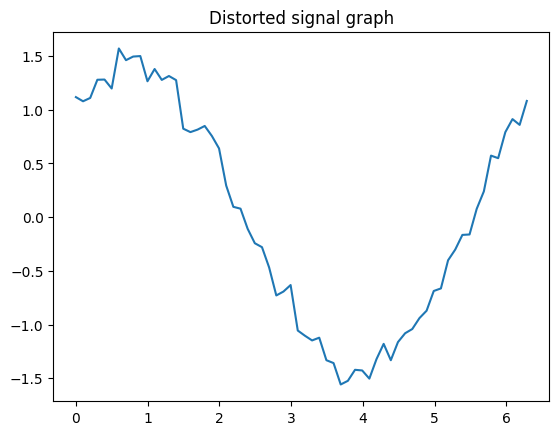

In [10]:
plt.plot(x, y_noisy)
plt.title('Distorted signal graph')

### Amplitude

Text(0.5, 1.0, 'Distorted signal graph')

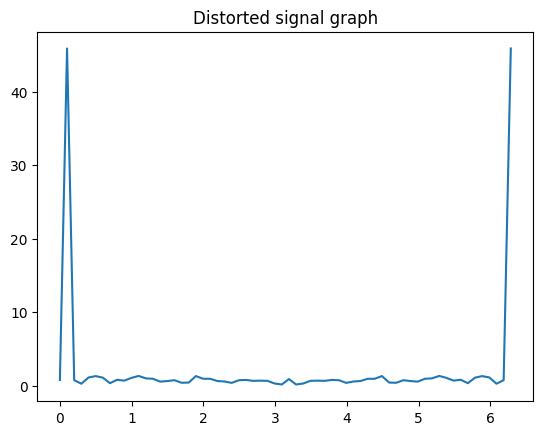

In [11]:
plt.plot(x, np.absolute(np.fft.fft(y_noisy)))
plt.title('Distorted signal graph')

## Band-stop filter

$$H(s)= \dfrac{s^2 + w_0^2} {s^2 + \dfrac {w_0}{Q} \cdot s + w_0^2} $$

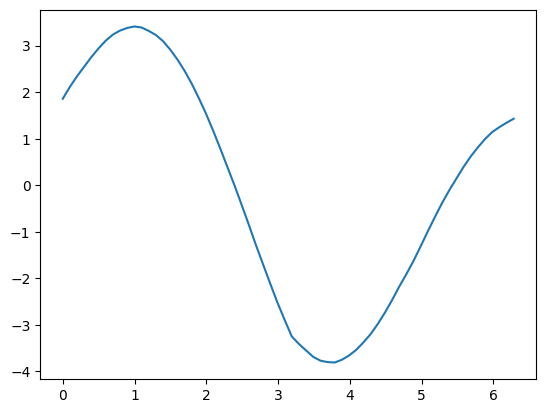

In [17]:
y_filtered = band_stop_filter(N)
plt.plot(x, y_filtered)

### Amplitude

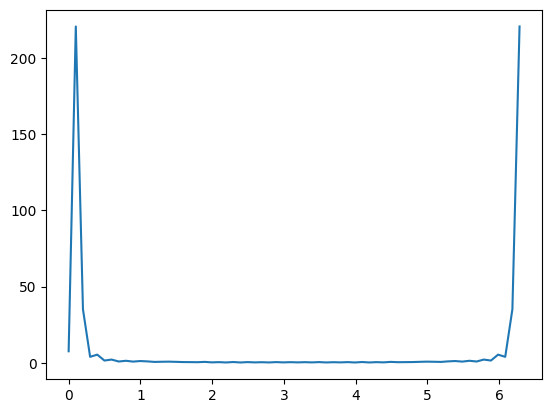

In [13]:
plt.plot(x, np.absolute(np.fft.fft(y_filtered)))

## Chebyshev filter

$$
H_n=\dfrac{1} {\sqrt{1 + \varepsilon^2 T_n^2(\dfrac{\omega} {\omega_0}) }} \\
\text{$\varepsilon$ -- maximum passband ripple allowed in the filter's magnitude response \\
$T_n$ -- the Chebyshev polynomial of order $n$ \\
$\omega$ -- the frequency \\
$\omega_0$ -- the cutoff frequency of the filter}
$$

#### Chebyshev polynomial
$$
 T_0(x)=1 \\
 T_1(x)=x \\
 T_{n+1}=2xT_n(x)-T_{n-1}(x)
$$

b=array([ 0.00000000e+00,  2.03810180e+00, -1.13137377e-16, -1.00954088e-01,
        8.83885759e-19,  6.25074758e-04])
a=array([2.00000000e+00, 0.00000000e+00, 9.90667769e-02, 0.00000000e+00,
       6.13389143e-04, 0.00000000e+00])


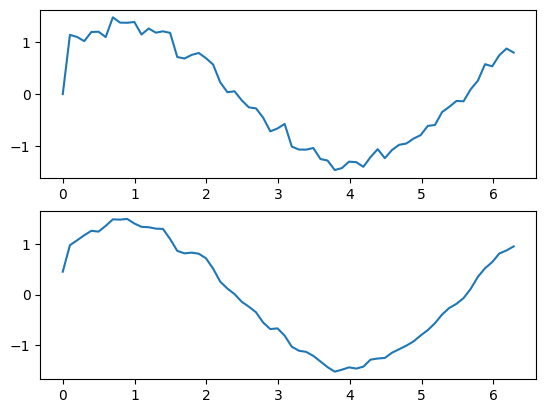

In [18]:
# filter definition
order = 1
fc = 0.5
rp = 5

# filter coefficient calculation
sos = cheby1(order, rp, fc, output='sos')

# signal filtering
y_filtered_cheby_scipy = sosfilt(sos, y_noisy)


order = 4
ripple = 3 # in dB
Wn = 0.3 # cutoff frequency
b, a = cheby_filter(order, ripple, Wn)
# y_filtered_cheby = np.convolve(y_noisy, b, mode='same')
# y_filtered_cheby = np.convolve(y_noisy, a, mode='same')
y_filtered_cheby = lfilter(b, a, y_noisy)

plt.subplot(211)
plt.plot(x, y_filtered_cheby)
plt.subplot(212)
plt.plot(x, y_filtered_cheby_scipy)

### Amplitude

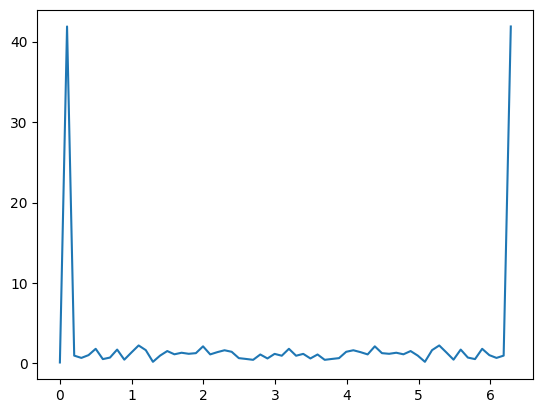

In [15]:
plt.plot(x, np.absolute(np.fft.fft(y_filtered_cheby)))